# import

In [24]:
from control import matlab
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg

# マイクラス，ファンクション

## パラメータ用クラス

In [26]:
class susParam:
    """
    サスペンションごとのパラメータを保存するためのクラス

    """
    ms_max = 2000  # kg : msの上限値
    ms_min = 1100  # kg : msの下限値

    ls = 4  # m : 車体全長
    lsf = 2  # m : 重心から前軸までの距離
    lsr = 2  # m : 重心から後ろ軸までの距離
    lfr = lsf+lsr  # 前輪から後輪までの距離

    Ts = 0.01

    def __init__(self):
        self.ms = 1500  # kg : 車体重量p
        self.muf = 20  # kg : 前輪重量
        self.mur = 20  # kg : 後輪重量

        self.ksf = 14000  # N/m : 前輪-車体間のバネ係数
        self.ksr = 15000  # N/m : 後輪-車体間のバネ係数
        self.ktf = 16000  # N/m : 路面-前輪間のバネ係数
        self.ktr = 19000  # N/m : 路面-後輪間のバネ係数

        self.csf = 1800  # N/m/s : 前輪のダンパ係数
        self.csr = 1900  # N/m/s : 後輪のダンパ係数

        self.v = 20  # km/h : 車体速度

        self.q = np.array(
            [1, 1, 100, 1, 1, 1, 1, 1]
        )
        self.r = np.array(
            [1, 1]
        )
        self.r = self.r*10**-8

    def update(self):
        ms = self.ms
        muf = self.muf
        mur = self.mur

        ksf = self.ksf
        ksr = self.ksr
        ktf = self.ktf
        ktr = self.ktr

        csf = self.csf
        csr = self.csr

        ls = self.ls
        lsf = self.lsf
        lsr = self.lsr

        q = self.q
        r = self.r

        v = self.v

        self.Is = ms*ls*ls/12  # ばね上慣性モーメント
        Is = self.Is
        self.vsec = v*1000/3600  # m/s 秒速
        self.tfr = self.lfr/self.vsec  # 前輪と後輪が同じ地点を通るまでにかかる時間

        # 重み行列
        self.Q = np.diag(q)
        self.R = np.diag(r)

        # 状態方程式
        self.Ap = np.zeros((8, 8))
        self.Ap[0] = np.array([0, 1, 0, 0, 0, 0, 0, 0])
        self.Ap[2] = np.array([0, 0, 0, 1, 0, 0, 0, 0])
        self.Ap[4] = np.array([0, 0, 0, 0, 0, 1, 0, 0])
        self.Ap[6] = np.array([0, 0, 0, 0, 0, 0, 0, 1])

        self.Ap[1] = np.array([-(ksf+ksr), -(csf+csr), ksf*lsf-ksr*lsr,
                               csf*lsf-csr*lsr, ksf, csf, ksr, csr])/ms
        self.Ap[3] = np.array([lsf*ksf-lsr*ksr, lsf*csf-lsr*csr, -(lsf*lsf*ksf+lsr*lsr*ksr), -(lsf*lsf*csf+lsr*lsr*csr),
                               -lsf*ksf, -lsf*csf, lsr*ksr, lsr*csr])/Is
        self.Ap[5] = np.array(
            [ksf, csf, -lsf*ksf, -lsf*csf, -(ksf+ktf), -csf, 0, 0])/muf
        self.Ap[7] = np.array(
            [ksr, csr, lsr*ksr, lsr*csr, 0, 0, -(ksr+ktr), -csr])/mur

        self.Ep = np.array(
            [
                [0, 0],
                [0, 0],
                [0, 0],
                [0, 0],
                [0, 0],
                [ktf/muf, 0],
                [0, 0],
                [0, ktr/mur]
            ]
        )

        self.Bp = np.array(
            [
                [0, 0],
                [1/ms, 1/ms],
                [0, 0],
                [-lsf/Is, lsr/Is],
                [0, 0],
                [-1/muf, 0],
                [0, 0],
                [0, -1/mur]
            ]
        )

        self.Cp = np.eye(8)

        self.Dp = np.zeros((8, 2))

        self.sysd = mycontrol()
        self.sysd.ss(self.Ap, self.Bp, self.Ep,
                              self.Cp, self.Dp, self.Ts)

    def clock(self, end, start=0):
        return np.arange(start, end, self.Ts)

## コントロールクラス

In [25]:
class mycontrol:
    """
    離散システム用
    y(k+1) = Ad*x(k) + Bd*u(k) + Ed*d(k) 想定
    """
        
    def ss(self, A, B, E, C, D, Ts):
        sys = matlab.ss(A, B, C, D)
        sysd = matlab.c2d(sys, Ts)
        self.Ad = sysd.A
        self.Bd = sysd.B
        self.Cd = sysd.C
        self.Dd = sysd.D
        sys = matlab.ss(A, E, C, D)
        sysd = matlab.c2d(sys, Ts)
        self.Ed = sysd.B

    def lqr(self, A, B, Q, R):
        """
        離散系最適レギュレータ
        """

        P = linalg.solve_discrete_are(A, B, Q, R)
        K = linalg.inv(R+B.T.dot(P).dot(B)).dot(B.T).dot(P).dot(A)
        E = None

        return P, K, E

## 外乱関数

In [23]:
def dstep(x, d, h):
    if x < d:
        return 0
    else:
        return h
    
def dstep_inv(x, d, h):
    if x < d:
        return -h
    else:
        return 0
    
def dsin(x, d, h):
    if x < d:
        return 0
    else:
        return h*np.sin((x-d)*susParam.Ts*3)
    
def dsawtooth(x, d1, d2, h):
    if x < d1:
        return 0
    elif x < d2:
        return (x-d1)*h/(d2-d1)
    else:
        return 0

# シミュレーション1

## 共通パラメータ

In [27]:
dh = 0.5
dd = 0
dd2 = dd + 15
lfr = susParam.lfr

mode = 20

def dist(x):
    # step
    if mode==10:
        df = dstep(x, dd, dh)
        dr = dstep(x-lfr, dd, dh)
    if mode==11:
        df = dstep_inv(x, dd, dh)
        dr = dstep_inv(x, dd, dh)
    # sin
    if mode==20:
        df = dsin(x, dd, dh)
        dr = dsin(x-lfr, dd, dh)
    # sawtooth
    if mode==30:
        df = dsawtooth(x, dd, dd2, dh)
        dr = dsawtooth(x-lfr, dd, dd2, dh)
    return np.array([[df], [dr]])

end_time = 15
t = susParam().clock(end_time)

### 外乱実験

In [33]:
v = 20
Ts = 0.001

print('lfr =', lfr)
print('v = ', v)
print('Ts =', Ts)
Mmax = lfr/(v*Ts)
print('M <= Mmax =', Mmax)

lfr = 4
v =  20
Ts = 0.001
M <= Mmax = 200.0


In [40]:
def distt(k):
    df = dsin(v*k*Ts, dd, dh)
    dr = dsin(v*k*Ts - lfr, dd, dh)
    return (df, dr)

def distd(x):
    return dsin(x, dd, dh)

In [43]:
print('d(4/Ts) =', distt(4/Ts))
print('d(4/Ts-Mmax) =', distt(4/Ts-Mmax))

d(4/Ts) = (0.3377315902755753, 0.37944035409046095)
d(4/Ts-Mmax) = (0.37944035409046095, 0.4156917303893416)


20
13


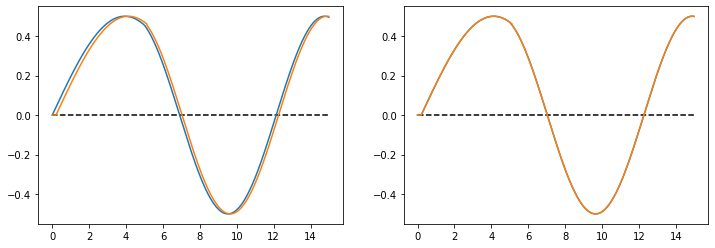

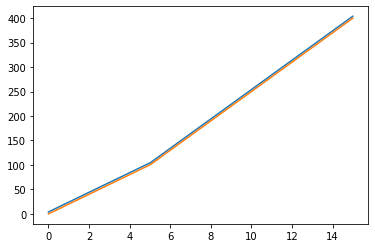

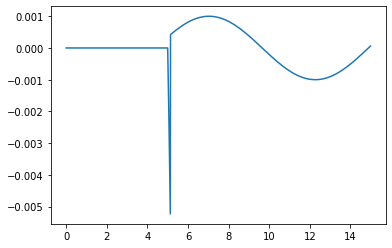

In [90]:
dh = 0.5
dd = 0
lfr = 4

def dist(x):
    if x < lfr:
        return 0
    else:
        return dh*np.sin((x-lfr)/50)

Ts = 0.01
t = np.arange(0, 15, Ts)
f = np.zeros((t.size))
f[0] = lfr
r = np.zeros((t.size))
df = np.zeros((t.size))
dr = np.zeros((t.size))
yoken = np.zeros((t.size))

s1 = 500

v = 20
vts = v*Ts
Mmax = int(lfr/(v*Ts))
print(Mmax)
for k in range(0, s1):
    f[k+1] = f[k] + v*Ts
    df[k+1] = dist(f[k+1])
    r[k+1] = r[k] + v*Ts
    dr[k+1] = dist(r[k+1])
    yoken[k+1+Mmax] = df[k+1]
    
v = 30
vts = v*Ts
Mmax = int(lfr/(v*Ts))
print(Mmax)
for k in range(s1, t.size-1-Mmax):
    f[k+1] = f[k] + vts
    df[k+1] = dist(f[k+1])
    r[k+1] = r[k] + vts
    dr[k+1] = dist(r[k+1])
    yoken[k+1+Mmax] = df[k+1]
    
for k in range(t.size-1-Mmax, t.size-1):
    f[k+1] = f[k] + vts
    df[k+1] = dist(f[k+1])
    r[k+1] = r[k] + vts
    dr[k+1] = dist(r[k+1])
    
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, df)
plt.plot(t, yoken)
plt.hlines([0], 0, 15, linestyles='dashed')
plt.subplot(1, 2, 2)
plt.plot(t, dr)
plt.plot(t, yoken)
plt.hlines([0], 0, 15, linestyles='dashed')

plt.figure()
plt.plot(t, f)
plt.plot(t, r)

a = dr-yoken
plt.figure()
plt.plot(t, a)

49.993333333334895 8 8.001066808907604 0.006666666666666667


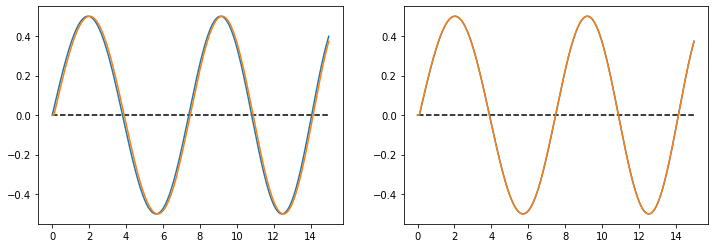

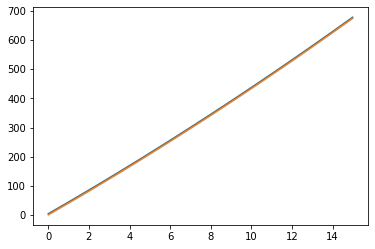

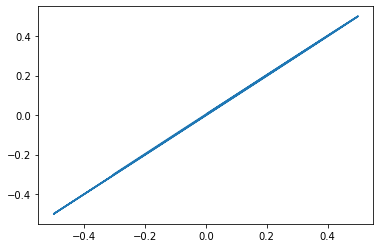

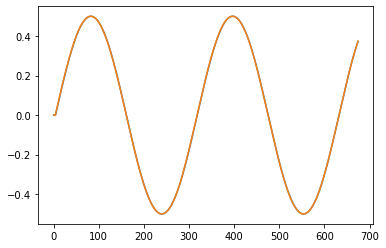

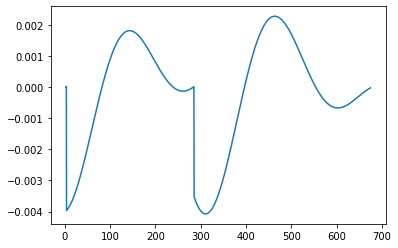

In [147]:
dh = 0.5
dd = 0
dd2 = 10
lfr = 4

# def dist(x):
#     if x < dd:
#         return 0
#     elif x < dd2:
#         return (x-dd)*dh/(dd2-dd)
#     else:
#         return 0

# def dist(x):
#     if x < dd:
#         return 0
#     else:
#         return dh

def dist(x):
    if x < lfr:
        return 0
    else:
        return dh*np.sin((x-lfr)/50)

Ts = 0.01
t = np.arange(0, 15, Ts)
f = np.zeros((t.size+100))
f[0] = lfr
r = np.zeros((t.size+100))
df = np.zeros((t.size+100))
dr = np.zeros((t.size+100))
yoken = np.zeros((t.size+100))
yokend = np.zeros((t.size+100))

v = 40
sec = 15
vplus = 50
a = (30-20)*Ts/sec
for k in range(t.size-1):
    Mmax = int(lfr/(v*Ts))
    f[k+1] = f[k] + v*Ts
    df[k+1] = dist(f[k+1])
    r[k+1] = r[k] + v*Ts
    dr[k+1] = dist(r[k+1])
    yoken[k+1+Mmax] = df[k+1]
    
    v += a
    
print(v, Mmax, lfr/(v*Ts), a)
    
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, df[:t.size])
plt.plot(t, yoken[:t.size])
plt.hlines([0], 0, 15, linestyles='dashed')

plt.subplot(1, 2, 2)
plt.plot(t, dr[:t.size])
plt.plot(t, yoken[:t.size])
plt.hlines([0], 0, 15, linestyles='dashed')

plt.figure()
plt.plot(t, f[:t.size])
plt.plot(t, r[:t.size])

plt.figure()
plt.plot(dr[Mmax+1:t.size], yoken[Mmax+1:t.size])

plt.figure()
plt.plot(r[:t.size], dr[:t.size])
plt.plot(r[:t.size], yoken[:t.size])

a = dr-yoken
plt.figure()
plt.plot(r[Mmax+1:t.size], a[Mmax+1:t.size])
# plt.hlines([0], 0, 15, linestyles='dashed')

150


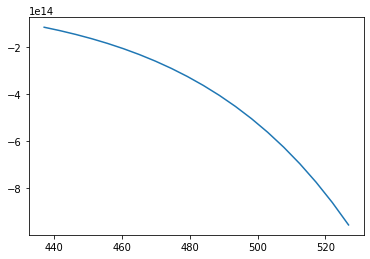

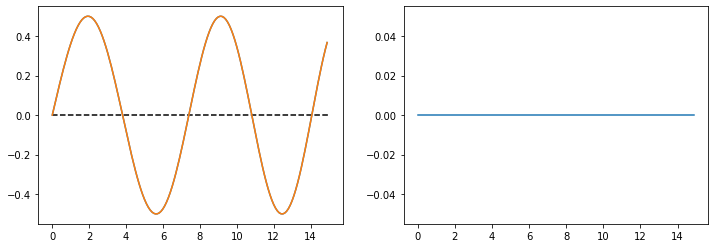

In [188]:
from scipy.interpolate import lagrange

dh = 0.5
lfr = 4

def dist(x):
    if x < lfr:
        return 0
    else:
        return dh*np.sin((x-lfr)/50)

Ts = 0.1
t = np.arange(0, 15, Ts)
f = np.zeros((t.size+100))
f[0] = lfr
r = np.zeros((t.size+100))
df = np.zeros((t.size+100))
dr = np.zeros((t.size+100))
yoken = np.zeros((t.size+100))
dyoken = np.zeros((t.size+100))
dryoken = np.zeros((t.size+100))

v = 40
sec = 15
vplus = 50
a = (30-20)*Ts/sec
num = 100
step = 20
for k in range(t.size-1):
    Mmax = int(lfr/(v*Ts))
    f[k+1] = f[k] + v*Ts
    df[k+1] = dist(f[k+1])
    r[k+1] = r[k] + v*Ts
    dr[k+1] = dist(r[k+1])
    yoken[k+1] = f[k+1]
    dyoken[k+1] = df[k+1]
    if k < Mmax:
        i = 0
    else:
        i = k-Mmax
    f_lag = lagrange(yoken[i:k], dyoken[i:k])
    dryoken[k+1] = f_lag(r[k+1])
    
    v += a
print(t.size)
    
f_lag = lagrange(yoken[100:120], dyoken[100:120])
plt.figure()
plt.plot(yoken[100:120], f_lag(yoken[100:120]))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, df[:t.size])
plt.plot(t, dyoken[:t.size])
plt.hlines([0], 0, 15, linestyles='dashed')

plt.subplot(1, 2, 2)
# plt.plot(t, dr[:t.size])
plt.plot(t, dryoken[:t.size])

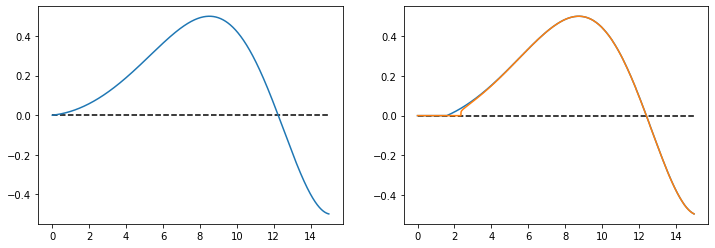

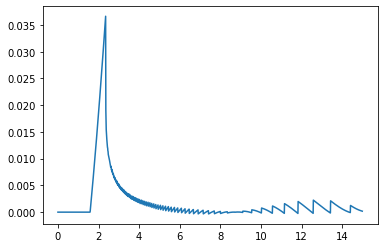

In [231]:
dh = 0.5
lfr = 4

def dist(x):
    if x < lfr:
        return 0
    else:
        return dh*np.sin((x-lfr)/50)

Ts = 0.01
t = np.arange(0, 15, Ts)
f = np.zeros((t.size))
f[0] = lfr
r = np.zeros((t.size))
df = np.zeros((t.size))
dr = np.zeros((t.size))
yoken = np.zeros((t.size+100))

v = 1
sec = 15
vplus = 30
a = (vplus-v)*Ts/sec
for k in range(t.size-1):
    Mmax = int(lfr/(v*Ts))
    f[k+1] = f[k] + v*Ts
    df[k+1] = dist(f[k+1])
    r[k+1] = r[k] + v*Ts
    dr[k+1] = dist(r[k+1])
    yoken[k+1+Mmax] = df[k+1]
    v += a

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, df[:t.size])
plt.hlines([0], 0, 15, linestyles='dashed')
plt.subplot(1, 2, 2)
plt.plot(t, dr[:t.size])
plt.plot(t, yoken[:t.size])
plt.hlines([0], 0, 15, linestyles='dashed')

dry = dr-yoken[:t.size]
plt.figure()
plt.plot(t, dry[:t.size])

In [224]:
from scipy.interpolate import lagrange

step = 20
ryoken = np.zeros((t.size))
dryoken = np.zeros((t.size))

func = lagrange(f, df)
ryoken = r
for k in range(t.size):
    if k < step:
        i = 0
    else:
        i = k-step

dryoken = func(r)

plt.plot(r, dr)
plt.plot(r, dryoken)

di= dr-dryoken
plt.figure()
plt.plot(r, di)

/usr/local/miniconda3/envs/python3_6_study/lib/python3.6/site-packages/numpy/lib/polynomial.py:789: RuntimeWarning: invalid value encountered in add
  val = a1 + a2
/usr/local/miniconda3/envs/python3_6_study/lib/python3.6/site-packages/numpy/lib/polynomial.py:792: RuntimeWarning: invalid value encountered in add
  val = NX.concatenate((zr, a1)) + a2


KeyboardInterrupt: 

## パッシブサスペンション

In [37]:
param = susParam()
param.update()

Ad = param.sysd.Ad
Bd = param.sysd.Bd
Ed = param.sysd.Ed
Cd = param.sysd.Cd
Dd = param.sysd.Dd

x = np.zeros((t.size, 8, 1))
y = np.zeros((t.size, 8, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 2, 1))
dis = np.zeros((t.size))
ddis = param.v*susParam.Ts

if mode==11:
    x[0] = np.array([[-dh, 0, 0, 0, -dh, 0, -dh, 0]]).T
    y[0] = np.array([[-dh, 0, 0, 0, -dh, 0, -dh, 0]]).T
    d[0] = np.array([[-dh, -dh]]).T

for i in range(t.size-1):
    x[i+1] = Ad.dot(x[i]) + Bd.dot(u[i]) + Ed.dot(d[i])
    y[i+1] = Cd.dot(x[i]) + Dd.dot(u[i])
    dis[i+1] = dis[i] + ddis
    d[i+1] = dist(dis[i+1])

pram1, x1, y1, u1, d1, dis1 = param, x, y, u, d, dis

## フィードバック制御

In [39]:
param = susParam()
param.update()

Ad = param.sysd.Ad
Bd = param.sysd.Bd
Ed = param.sysd.Ed
Cd = param.sysd.Cd
Dd = param.sysd.Dd
Q = param.Q
R = param.R

q = np.array(
            [1, 1, 100, 1, 1, 1, 1, 1]
        )
Q = np.diag(q)
h = np.ones((2))*10**-7
H = np.diag(h)

x = np.zeros((t.size, 8, 1))
y = np.zeros((t.size, 8, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 2, 1))
dis = np.zeros((t.size))

ddis = param.v*susParam.Ts

P, K, E = param.sysd.lqr(Ad, Bd, Q, H)
K = -K

if mode==11:
    x[0] = np.array([[-dh, 0, 0, 0, -dh, 0, -dh, 0]]).T
    y[0] = np.array([[-dh, 0, 0, 0, -dh, 0, -dh, 0]]).T
    d[0] = np.array([[-dh, -dh]]).T

for i in range(t.size-1):
    x[i+1] = Ad.dot(x[i]) + Bd.dot(u[i]) + Ed.dot(d[i])
    y[i+1] = Cd.dot(x[i]) + Dd.dot(u[i])
    dis[i+1] = dis[i] + ddis
    d[i+1] = dist(dis[i+1])
    
    u[i+1] = K.dot(x[i+1])

pram2, x2, y2, u2, d2, dis2 = param, x, y, u, d, dis
u2

array([[[ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 1.98908215e+01],
        [ 4.24142612e-01]],

       ...,

       [[-2.29707294e-03],
        [-1.83933534e-03]],

       [[-2.21283750e-03],
        [-1.75741157e-03]],

       [[-2.12797893e-03],
        [-1.67528163e-03]]])

In [25]:
K

matrix([[ 4047.19725238, -1268.77983157, -4632.96016052,  2091.53304332,
           -66.92097914,   606.54203586, -4233.05241867,    14.28830476],
        [ 4922.56822888, -1012.3160806 ,  3634.02089392, -2304.49641679,
         -4223.19627924,    21.98296989,   -98.45338877,   573.88122585]])

## エラーシステム

In [77]:
param = susParam()
param.update()

Ad = param.sysd.Ad
Bd = param.sysd.Bd
Ed = param.sysd.Ed
Cd = param.sysd.Cd
Dd = param.sysd.Dd

phi = np.vstack((
    np.hstack((np.eye(8), -Cd.dot(Ad))),
    np.hstack((np.zeros((8, 8)), Ad))
))
G = np.vstack((
    -Cd.dot(Bd),
    Bd
))
Gd = np.vstack((
    -Cd.dot(Ed),
    Ed
))

q1 = np.array(
            [1, 1, 100, 1, 1, 1, 1, 1]
        )
q2 = np.array(
            [1, 1, 100, 1, 1, 1, 1, 1]
        )
q = np.hstack((q1, q2))
Q = np.diag(q)
h = np.ones((2))*10**-3
H = np.diag(h)

P, K, E = mycontrol().lqr(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, 2)

x = np.zeros((t.size, 8, 1))
y = np.zeros((t.size, 8, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 2, 1))
dis = np.zeros((t.size))
r = np.zeros((t.size, 8, 1))
e = np.zeros((t.size, 8, 1))

ddis = param.v*susParam.Ts

if mode==11:
    x[0] = np.array([[-dh, 0, 0, 0, -dh, 0, -dh, 0]]).T
    y[0] = np.array([[-dh, 0, 0, 0, -dh, 0, -dh, 0]]).T
    d[0] = np.array([[-dh, -dh]]).T

for i in range(t.size-1):
    x[i+1] = Ad.dot(x[i]) + Bd.dot(u[i]) + Ed.dot(d[i])
    y[i+1] = Cd.dot(x[i]) + Dd.dot(u[i])
    dis[i+1] = dis[i] + ddis
    d[i+1] = dist(dis[i+1])
    
    e[i+1] = r[i+1]-y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    u[i+1] = u[i] + du

pram3, x3, y3, u3, d3, dis3, e3 = param, x, y, u, d, dis, e
u3

array([[[0.00000000e+00],
        [0.00000000e+00]],

       [[0.00000000e+00],
        [0.00000000e+00]],

       [[1.49650287e+02],
        [5.07596266e+02]],

       ...,

       [[1.55193151e+42],
        [4.94230604e+42]],

       [[1.67527630e+42],
        [5.32395888e+42]],

       [[1.80501088e+42],
        [5.72466588e+42]]])

# プロット1

## オールパラメータ

In [41]:
# sim1すべて実行

In [47]:
#fig1すべて表示

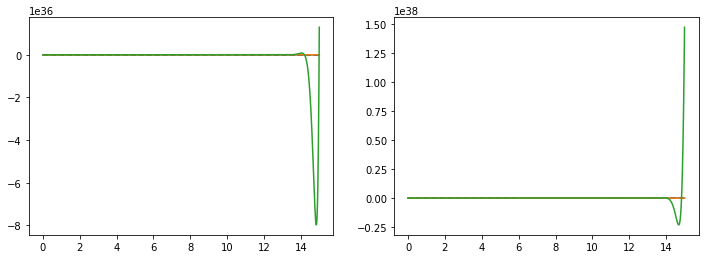

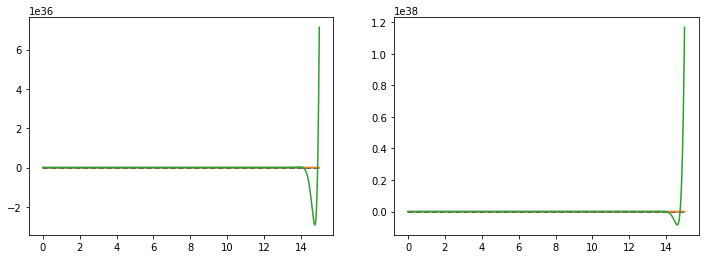

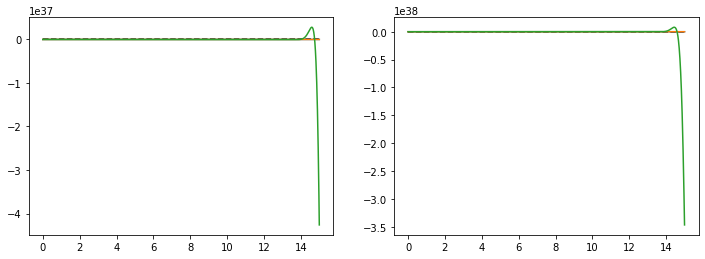

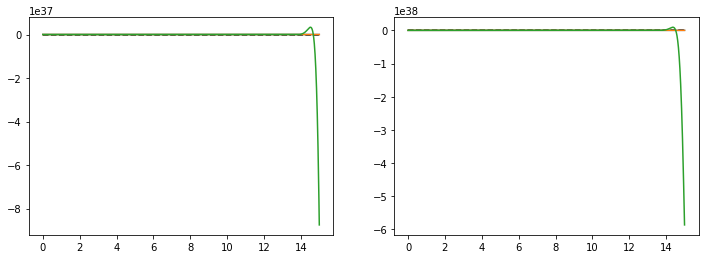

In [78]:
yn = (y1, y2, y3)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0])
plt.hlines([dh], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1])
plt.hlines([0], 0, end_time, linestyles='dashed')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3])
plt.hlines([0], 0, end_time, linestyles='dashed')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 4])
plt.hlines([dh], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 5])
plt.hlines([0], 0, end_time, linestyles='dashed')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 6])
plt.hlines([dh], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 7])
plt.hlines([0], 0, end_time, linestyles='dashed')

## 入力値

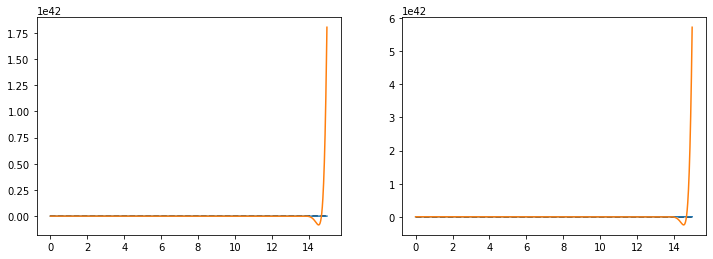

In [79]:
un = (u2, u3)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for u in un:
    plt.plot(t, u[:, 0])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for u in un:
    plt.plot(t, u[:, 1])
plt.hlines([0], 0, end_time, linestyles='dashed')

## 外乱

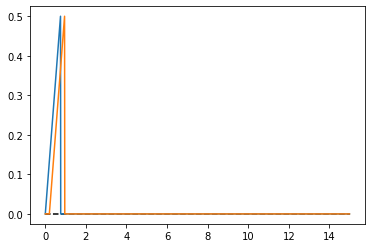

In [50]:
dn = (d3, )

for d in dn:
    plt.figure()
    plt.plot(t, d[:, 0])
    plt.plot(t, d[:, 1])
    plt.hlines([0], 0, end_time, linestyles='dashed')

## 移動距離

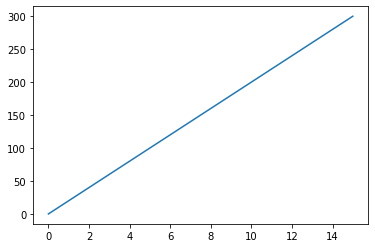

In [51]:
disn = (dis3, )

for dis in disn:
    plt.plot(t, dis)

## エラー信号

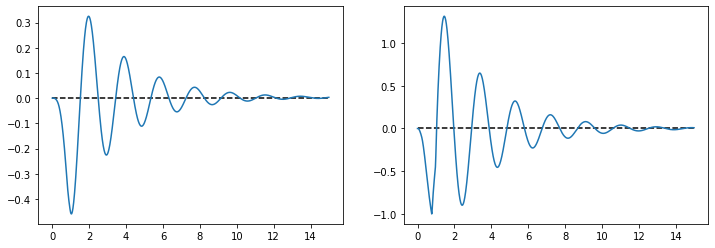

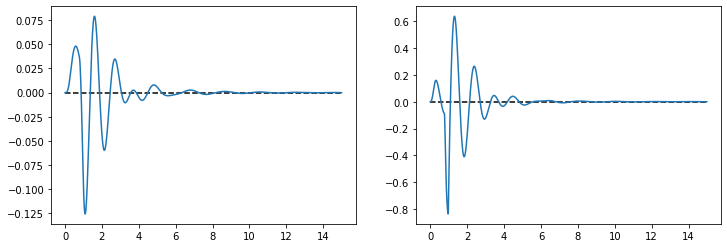

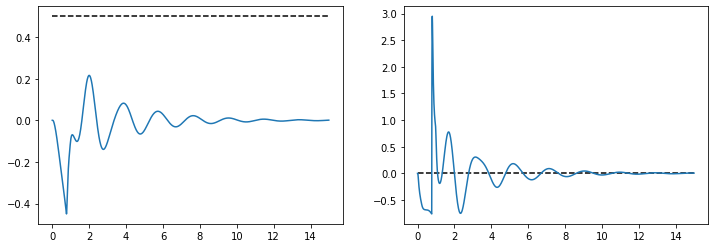

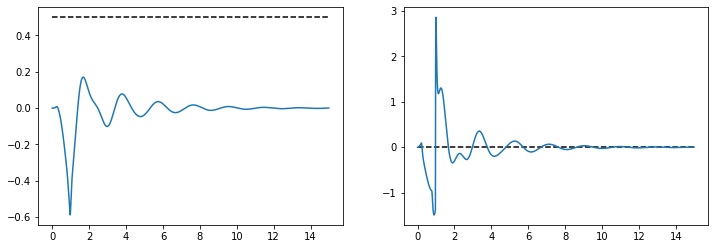

In [52]:
yn = (e3, )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 0])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 1])
plt.hlines([0], 0, end_time, linestyles='dashed')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 2])
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 3])
plt.hlines([0], 0, end_time, linestyles='dashed')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 4])
plt.hlines([dh], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 5])
plt.hlines([0], 0, end_time, linestyles='dashed')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for y in yn:
    plt.plot(t, y[:, 6])
plt.hlines([dh], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for y in yn:
    plt.plot(t, y[:, 7])
plt.hlines([0], 0, end_time, linestyles='dashed')